## 1. Data manipulation ##

In [ ]:
import numpy as np
## Progress bar
from tqdm.auto import tqdm
import pylab as plt
import copy
import time
import tensorflow as tf

In [ ]:
if 'google.colab' in str(get_ipython()):
  print("All ok -- code is running on a Google Colab")
else:
    print("==="*15, " WARNING ","==="*15)
    print("For DSA4212 assignment 1, code needs to be run on a Google Colab with a single GPU")
    print("==="*15, " WARNING ","==="*15)



All ok -- code is running on a Google Colab


In [ ]:
!nvidia-smi -L
!lscpu |grep 'Model name'
!free -h --si | awk  '/Mem:/{print $2}'

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Model name:                      AMD EPYC 7B12
12G


In [ ]:
# mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# goto to data folder -- you may need to change this location
%cd /content/drive/MyDrive/DSA4212/assignment_1_script/

/content/drive/MyDrive/DSA4212/assignment_1_script


In [ ]:
class_names=["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

# load data -- be patient, does take a few secs
data_train = np.load("assignment_1_train.npz")
data_val = np.load("assignment_1_val.npz")

X_train = data_train["img"].astype(np.float32) / 256.   # set pixel intensities to [0,1]
X_val = data_val["img"].astype(np.float32) / 256.
Y_train = data_train["label"].astype(int)
Y_val = data_val["label"].astype(int)

_,H,W,C = X_train.shape
print(f"Img Shape: {H}x{W}x{C}")


Img Shape: 128x128x3


In [ ]:
# shuffle the train set
indices_shuffled = np.arange(len(X_train))
np.random.shuffle(indices_shuffled)
X_train = X_train[indices_shuffled]
Y_train = Y_train[indices_shuffled]

# shuffle the validation set
indices_shuffled = np.arange(len(X_val))
np.random.shuffle(indices_shuffled)
X_val = X_val[indices_shuffled]
Y_val = Y_val[indices_shuffled]

In [ ]:
sz_train = X_train.size * X_train.itemsize / 2.**30
sz_val = X_val.size * X_train.itemsize / 2.**30

print(f"Training Set Size: {sz_train:2.2f} Go")
print(f"Validaton Set Size: {sz_val:2.2f} Go")

Training Set Size: 1.70 Go
Validaton Set Size: 0.71 Go


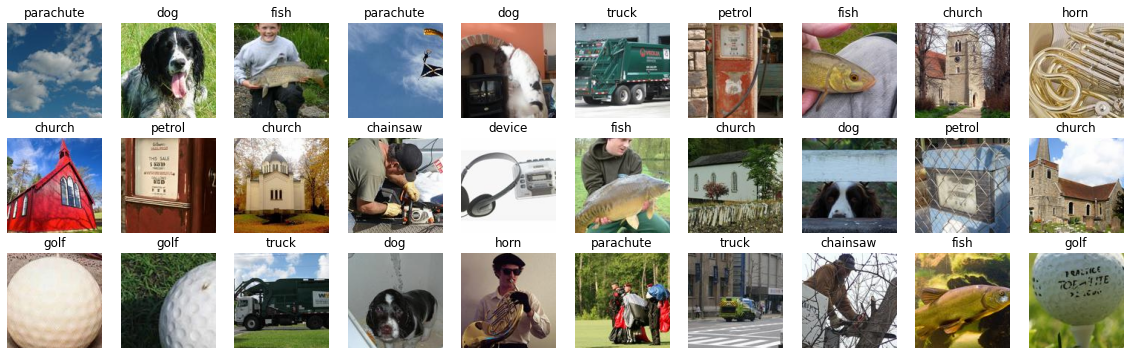

In [ ]:
# train set:: sanity check
# plt a few random images in the trainset as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_train))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_train[index,:,:,:])
    plt.title(class_names[Y_train[index]])

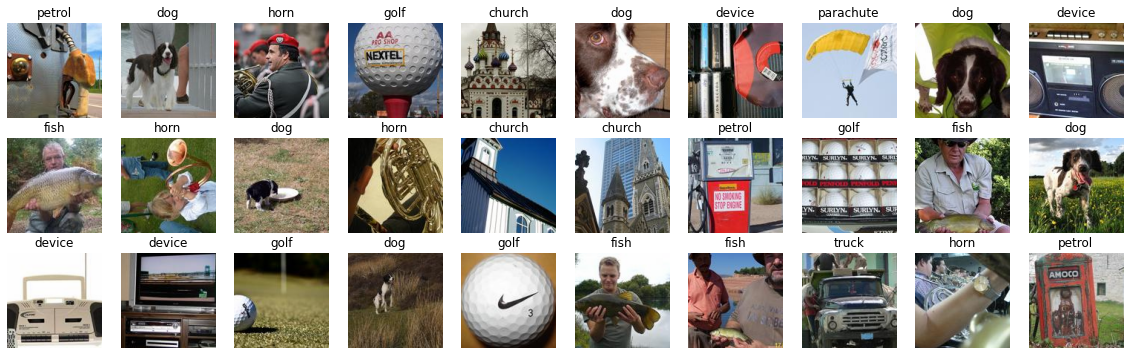

In [ ]:
# validation set:: sanity check
# plt a few images as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_val))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_val[index,:,:,:])
    plt.title(class_names[Y_val[index]])

In [ ]:
# load FLAX and install it if not installed already
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

import flax
from flax import linen as nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 9.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [ ]:
import jax
import jax.numpy as jnp
from typing import Any, Sequence

try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## 2. Overfit ##
- Fit all the models using the same loss functions and optimisation algorithms.
- However hyperparameters can be tuned for best results, so comparing best performance of each model.

## 1. Base CNN model increasing epoch to 1100 ##

In [ ]:
# Simple CNN model
# Source is from the flax documentation
# First change was to add two additional layers, one convultional layer and a relu

class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)

class CNN(nn.Module):
    """ a simple convolutional neural network """
    n_filters: Sequence[int]  # sequence -- number of CNN filters in each layer
    n_class: int              # number of possible classes
    
    @nn.compact
    def __call__(self, x):
        """
        inputs:
        ======
         inputs: batch of images of dimension (X,H,W,3)

        outputs:
        ======
         probas: predictive probability vector
        """
        
        # convolutional layers + normalization
        for i, feat_dim in enumerate(self.n_filters):
            x = LayerNorm()(x)
            x = nn.elu( nn.Conv(features=feat_dim, kernel_size=(3,3), strides = 2, padding='SAME')(x) )
            
        # pooling -- average across the dimension (1,2)
        x =  x.mean(axis=(1,2))
        
        # last dense layer
        x = nn.Dense(self.n_class)(x)
        
        #convert to proba
        probas = nn.softmax(x)
        return probas  
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
CNN_net = CNN(n_filters=[32,64,128], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key

key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = CNN_net.init(key_, batch_of_images)  

# Change the model type
# Loss function 
@jax.jit
def loss(params, x, y):
  """ cross-entropy loss
  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred = CNN_net.apply(params, x)
  y_hot = jax.nn.one_hot(y, n_class)
  CEs = -jnp.sum(y_hot * jnp.log(pred), axis=1)
  return jnp.mean(CEs)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

@jax.jit
def prediction_class(params, x):
  """ make a prediction """
  pred = CNN_net.apply(params, x)
  pred_class = jnp.argmax(pred, axis=1)
  return pred_class

@jax.jit
def accuracy(params, x, y):
  """
  compute the accuracy on a batch of images

  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred_class = prediction_class(params, x)
  return jnp.mean(pred_class == y)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

# let us randomize the weights again to start from scratch
params = copy.deepcopy(params_init)

#define the ADAM optimizer
optimizer = optax.adam(learning_rate=0.01, eps=0.001)

#generate the initial state of the optimizer
opt_state = optimizer.init(params)

# put data to GPU
X_train = jax.device_put(X_train)
X_val = jax.device_put(X_val)


In [ ]:
niter = 1100
batch_size = 512

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

In [ ]:
time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append(loss_train.item())

pred_val = []
n_forward_pass = len(X_val) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_val.append( prediction_class(params, X_val[k*batch_size:(k+1)*batch_size]) )
pred_val.append( prediction_class(params, X_val[n_forward_pass*batch_size:]) )

pred_val = np.concatenate(pred_val)
acc_validation = 100*jnp.mean(pred_val == Y_val)
print( f"Final Validation Accuracy: {acc_validation:2.1f}%")

  0%|          | 0/1100 [00:00<?, ?it/s]

Time:1.8sec 	 Epoch:0.1 	 Loss [2.31 / 2.31] 	 Accuracy Train/Valid: [8.20% / 6.84%]
Time:8.7sec 	 Epoch:2.8 	 Loss [1.43 / 1.46] 	 Accuracy Train/Valid: [55.27% / 47.46%]
Time:13.6sec 	 Epoch:5.6 	 Loss [1.26 / 1.17] 	 Accuracy Train/Valid: [63.28% / 60.35%]
Time:19.4sec 	 Epoch:8.3 	 Loss [1.10 / 1.07] 	 Accuracy Train/Valid: [69.92% / 64.84%]
Time:25.4sec 	 Epoch:11.1 	 Loss [0.86 / 0.95] 	 Accuracy Train/Valid: [72.85% / 68.95%]
Time:30.6sec 	 Epoch:13.8 	 Loss [0.83 / 0.91] 	 Accuracy Train/Valid: [76.37% / 72.07%]
Time:35.9sec 	 Epoch:16.6 	 Loss [0.85 / 0.87] 	 Accuracy Train/Valid: [78.91% / 71.68%]
Time:41.8sec 	 Epoch:19.3 	 Loss [0.82 / 0.85] 	 Accuracy Train/Valid: [80.27% / 73.24%]
Time:47.1sec 	 Epoch:22.1 	 Loss [0.63 / 0.83] 	 Accuracy Train/Valid: [81.05% / 75.78%]
Time:52.6sec 	 Epoch:24.8 	 Loss [0.63 / 0.80] 	 Accuracy Train/Valid: [80.66% / 74.22%]
Time:58.3sec 	 Epoch:27.6 	 Loss [0.64 / 0.76] 	 Accuracy Train/Valid: [85.94% / 76.17%]
Time:64.0sec 	 Epoch:30.3 	 L

  0%|          | 0/7 [00:00<?, ?it/s]

Final Validation Accuracy: 70.9%


## 2. Base CNN model with stride 3 ##

In [ ]:
# Simple CNN model
# Source is from the flax documentation
# First change was to add two additional layers, one convultional layer and a relu

class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)

class CNN(nn.Module):
    """ a simple convolutional neural network """
    n_filters: Sequence[int]  # sequence -- number of CNN filters in each layer
    n_class: int              # number of possible classes
    
    @nn.compact
    def __call__(self, x):
        """
        inputs:
        ======
         inputs: batch of images of dimension (X,H,W,3)

        outputs:
        ======
         probas: predictive probability vector
        """
        
        # convolutional layers + normalization
        for i, feat_dim in enumerate(self.n_filters):
            x = LayerNorm()(x)
            x = nn.elu( nn.Conv(features=feat_dim, kernel_size=(3,3), strides = 3, padding='SAME')(x) )
            
        # pooling -- average across the dimension (1,2)
        x =  x.mean(axis=(1,2))
        
        # last dense layer
        x = nn.Dense(self.n_class)(x)
        
        #convert to proba
        probas = nn.softmax(x)
        return probas  
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
CNN_net = CNN(n_filters=[32,64,128], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key

key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = CNN_net.init(key_, batch_of_images)  

# Change the model type
# Loss function 
@jax.jit
def loss(params, x, y):
  """ cross-entropy loss
  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred = CNN_net.apply(params, x)
  y_hot = jax.nn.one_hot(y, n_class)
  CEs = -jnp.sum(y_hot * jnp.log(pred), axis=1)
  return jnp.mean(CEs)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )


In [ ]:
niter = 1100
batch_size = 512

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

In [ ]:
time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append(loss_train.item())

pred_val = []
n_forward_pass = len(X_val) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_val.append( prediction_class(params, X_val[k*batch_size:(k+1)*batch_size]) )
pred_val.append( prediction_class(params, X_val[n_forward_pass*batch_size:]) )

pred_val = np.concatenate(pred_val)
acc_validation = 100*jnp.mean(pred_val == Y_val)
print( f"Final Validation Accuracy: {acc_validation:2.1f}%")

  0%|          | 0/1100 [00:00<?, ?it/s]

Time:2.3sec 	 Epoch:0.1 	 Loss [2.32 / 2.32] 	 Accuracy Train/Valid: [10.35% / 8.79%]
Time:6.3sec 	 Epoch:2.8 	 Loss [1.40 / 1.52] 	 Accuracy Train/Valid: [59.77% / 50.20%]
Time:8.5sec 	 Epoch:5.6 	 Loss [1.13 / 1.31] 	 Accuracy Train/Valid: [73.83% / 58.20%]
Time:10.6sec 	 Epoch:8.3 	 Loss [0.83 / 1.25] 	 Accuracy Train/Valid: [81.84% / 58.20%]
Time:12.8sec 	 Epoch:11.1 	 Loss [0.58 / 1.27] 	 Accuracy Train/Valid: [86.13% / 58.79%]
Time:15.0sec 	 Epoch:13.8 	 Loss [0.47 / 1.33] 	 Accuracy Train/Valid: [88.28% / 59.57%]
Time:17.8sec 	 Epoch:16.6 	 Loss [0.38 / 1.40] 	 Accuracy Train/Valid: [92.58% / 56.05%]
Time:20.1sec 	 Epoch:19.3 	 Loss [0.22 / 1.49] 	 Accuracy Train/Valid: [96.68% / 56.64%]
Time:22.2sec 	 Epoch:22.1 	 Loss [0.22 / 1.55] 	 Accuracy Train/Valid: [96.68% / 58.40%]
Time:24.4sec 	 Epoch:24.8 	 Loss [0.18 / 1.76] 	 Accuracy Train/Valid: [93.75% / 55.08%]
Time:26.5sec 	 Epoch:27.6 	 Loss [0.10 / 1.63] 	 Accuracy Train/Valid: [98.63% / 59.96%]
Time:28.7sec 	 Epoch:30.3 	 L

  0%|          | 0/7 [00:00<?, ?it/s]

Final Validation Accuracy: 55.8%


## 3. Base CNN model with nn.avg_pool ##

In [ ]:
# Simple CNN model
# Source is from the flax documentation
# First change was to add two additional layers, one convultional layer and a relu

class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)

class CNN(nn.Module):
    """ a simple convolutional neural network """
    n_filters: Sequence[int]  # sequence -- number of CNN filters in each layer
    n_class: int              # number of possible classes
    
    @nn.compact
    def __call__(self, x):
        """
        inputs:
        ======
         inputs: batch of images of dimension (X,H,W,3)

        outputs:
        ======
         probas: predictive probability vector
        """
        
        # convolutional layers + normalization
        for i, feat_dim in enumerate(self.n_filters):
            x = LayerNorm()(x)
            x = nn.elu( nn.Conv(features=feat_dim, kernel_size=(3,3), strides = 2, padding='SAME')(x) )
            x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
            
        # pooling -- average across the dimension (1,2)
        x =  x.mean(axis=(1,2))
        
        # last dense layer
        x = nn.Dense(self.n_class)(x)
        
        #convert to proba
        probas = nn.softmax(x)
        return probas  
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
CNN_net = CNN(n_filters=[32,64,128], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key

key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = CNN_net.init(key_, batch_of_images)  



In [ ]:
niter = 1000
batch_size = 512

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

In [ ]:
time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append(loss_train.item())

pred_val = []
n_forward_pass = len(X_val) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_val.append( prediction_class(params, X_val[k*batch_size:(k+1)*batch_size]) )
pred_val.append( prediction_class(params, X_val[n_forward_pass*batch_size:]) )

pred_val = np.concatenate(pred_val)
acc_validation = 100*jnp.mean(pred_val == Y_val)
print( f"Final Validation Accuracy: {acc_validation:2.1f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time:4.6sec 	 Epoch:0.1 	 Loss [2.32 / 2.32] 	 Accuracy Train/Valid: [9.96% / 8.40%]
Time:9.6sec 	 Epoch:2.8 	 Loss [1.44 / 1.48] 	 Accuracy Train/Valid: [54.69% / 49.41%]
Time:12.1sec 	 Epoch:5.6 	 Loss [1.20 / 1.26] 	 Accuracy Train/Valid: [65.82% / 58.20%]
Time:14.9sec 	 Epoch:8.3 	 Loss [0.98 / 1.20] 	 Accuracy Train/Valid: [75.20% / 58.79%]
Time:17.6sec 	 Epoch:11.1 	 Loss [0.62 / 1.06] 	 Accuracy Train/Valid: [83.20% / 65.62%]
Time:20.1sec 	 Epoch:13.8 	 Loss [0.52 / 1.13] 	 Accuracy Train/Valid: [82.81% / 64.65%]
Time:22.6sec 	 Epoch:16.6 	 Loss [0.54 / 1.25] 	 Accuracy Train/Valid: [83.59% / 63.28%]
Time:25.1sec 	 Epoch:19.3 	 Loss [0.30 / 1.19] 	 Accuracy Train/Valid: [91.80% / 66.60%]
Time:27.9sec 	 Epoch:22.1 	 Loss [0.22 / 1.30] 	 Accuracy Train/Valid: [95.51% / 62.30%]
Time:30.7sec 	 Epoch:24.8 	 Loss [0.19 / 1.43] 	 Accuracy Train/Valid: [91.21% / 64.45%]
Time:33.2sec 	 Epoch:27.6 	 Loss [0.15 / 1.43] 	 Accuracy Train/Valid: [96.29% / 62.89%]
Time:35.7sec 	 Epoch:30.3 	 L

  0%|          | 0/7 [00:00<?, ?it/s]

Final Validation Accuracy: 60.0%


## 4. Changing from elu to relu ##

In [ ]:
# Simple CNN model
# Source is from the flax documentation
# First change was to add two additional layers, one convultional layer and a relu

class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)

class CNN(nn.Module):
    """ a simple convolutional neural network """
    n_filters: Sequence[int]  # sequence -- number of CNN filters in each layer
    n_class: int              # number of possible classes
    
    @nn.compact
    def __call__(self, x):
        """
        inputs:
        ======
         inputs: batch of images of dimension (X,H,W,3)

        outputs:
        ======
         probas: predictive probability vector
        """
        
        # convolutional layers + normalization
        for i, feat_dim in enumerate(self.n_filters):
            x = LayerNorm()(x)
            x = nn.relu( nn.Conv(features=feat_dim, kernel_size=(3,3), strides = 2, padding='SAME')(x) )
            
            
        # pooling -- average across the dimension (1,2)
        x =  x.mean(axis=(1,2))
        
        # last dense layer
        x = nn.Dense(self.n_class)(x)
        
        #convert to proba
        probas = nn.softmax(x)
        return probas  
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
CNN_net = CNN(n_filters=[32,64,128], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key

key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = CNN_net.init(key_, batch_of_images)  



In [ ]:
niter = 1000
batch_size = 512

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

In [ ]:
time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append(loss_train.item())

pred_val = []
n_forward_pass = len(X_val) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_val.append( prediction_class(params, X_val[k*batch_size:(k+1)*batch_size]) )
pred_val.append( prediction_class(params, X_val[n_forward_pass*batch_size:]) )

pred_val = np.concatenate(pred_val)
acc_validation = 100*jnp.mean(pred_val == Y_val)
print( f"Final Validation Accuracy: {acc_validation:2.1f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time:0.0sec 	 Epoch:0.1 	 Loss [0.22 / 0.85] 	 Accuracy Train/Valid: [92.97% / 75.20%]
Time:6.1sec 	 Epoch:2.8 	 Loss [0.19 / 0.83] 	 Accuracy Train/Valid: [95.12% / 75.20%]
Time:11.0sec 	 Epoch:5.6 	 Loss [0.22 / 0.88] 	 Accuracy Train/Valid: [94.53% / 75.39%]
Time:16.3sec 	 Epoch:8.3 	 Loss [0.21 / 0.91] 	 Accuracy Train/Valid: [93.75% / 75.78%]
Time:21.3sec 	 Epoch:11.1 	 Loss [0.13 / 0.91] 	 Accuracy Train/Valid: [97.46% / 74.41%]
Time:26.3sec 	 Epoch:13.8 	 Loss [0.16 / 0.95] 	 Accuracy Train/Valid: [94.14% / 74.80%]
Time:31.6sec 	 Epoch:16.6 	 Loss [0.17 / 0.93] 	 Accuracy Train/Valid: [96.68% / 75.00%]
Time:36.5sec 	 Epoch:19.3 	 Loss [0.12 / 0.90] 	 Accuracy Train/Valid: [98.05% / 72.85%]
Time:41.9sec 	 Epoch:22.1 	 Loss [0.08 / 0.89] 	 Accuracy Train/Valid: [99.61% / 75.59%]
Time:47.1sec 	 Epoch:24.8 	 Loss [0.14 / 1.07] 	 Accuracy Train/Valid: [91.99% / 69.92%]
Time:52.4sec 	 Epoch:27.6 	 Loss [0.11 / 0.94] 	 Accuracy Train/Valid: [98.05% / 74.61%]
Time:57.8sec 	 Epoch:30.3 	

  0%|          | 0/7 [00:00<?, ?it/s]

Final Validation Accuracy: 70.3%


## 5. Add a maxpool ##

In [ ]:
# Simple CNN model
# Source is from the flax documentation
# First change was to add two additional layers, one convultional layer and a relu

class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)

class CNN(nn.Module):
    """ a simple convolutional neural network """
    n_filters: Sequence[int]  # sequence -- number of CNN filters in each layer
    n_class: int              # number of possible classes
    
    @nn.compact
    def __call__(self, x):
        """
        inputs:
        ======
         inputs: batch of images of dimension (X,H,W,3)

        outputs:
        ======
         probas: predictive probability vector
        """
        
        # convolutional layers + normalization
        for i, feat_dim in enumerate(self.n_filters):
            x = LayerNorm()(x)
            x = nn.Conv(features=feat_dim, kernel_size=(3,3), strides = 2, padding='SAME')(x)
            x = nn.max_pool(x,window_shape = (2,2))
            x = nn.elu(x)
            
            
        # pooling -- average across the dimension (1,2)
        x =  x.mean(axis=(1,2))

        
        # last dense layer
        x = nn.Dense(self.n_class)(x)
        
        #convert to proba
        probas = nn.softmax(x)
        return probas  
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
CNN_net = CNN(n_filters=[32,64,128], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key

key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = CNN_net.init(key_, batch_of_images)  



In [ ]:
niter = 1000
batch_size = 512

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

In [ ]:
time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append(loss_train.item())

pred_val = []
n_forward_pass = len(X_val) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_val.append( prediction_class(params, X_val[k*batch_size:(k+1)*batch_size]) )
pred_val.append( prediction_class(params, X_val[n_forward_pass*batch_size:]) )

pred_val = np.concatenate(pred_val)
acc_validation = 100*jnp.mean(pred_val == Y_val)
print( f"Final Validation Accuracy: {acc_validation:2.1f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time:0.0sec 	 Epoch:0.1 	 Loss [0.05 / 1.05] 	 Accuracy Train/Valid: [99.41% / 73.44%]
Time:5.3sec 	 Epoch:2.8 	 Loss [0.04 / 1.12] 	 Accuracy Train/Valid: [99.02% / 72.46%]
Time:10.5sec 	 Epoch:5.6 	 Loss [0.04 / 1.16] 	 Accuracy Train/Valid: [99.80% / 73.05%]
Time:15.4sec 	 Epoch:8.3 	 Loss [0.03 / 1.15] 	 Accuracy Train/Valid: [99.02% / 73.83%]
Time:20.2sec 	 Epoch:11.1 	 Loss [0.04 / 1.14] 	 Accuracy Train/Valid: [99.22% / 71.48%]
Time:25.4sec 	 Epoch:13.8 	 Loss [0.09 / 1.31] 	 Accuracy Train/Valid: [97.46% / 68.75%]
Time:30.8sec 	 Epoch:16.6 	 Loss [0.03 / 1.19] 	 Accuracy Train/Valid: [100.00% / 72.66%]
Time:36.1sec 	 Epoch:19.3 	 Loss [0.01 / 1.11] 	 Accuracy Train/Valid: [100.00% / 72.27%]
Time:41.0sec 	 Epoch:22.1 	 Loss [0.01 / 1.11] 	 Accuracy Train/Valid: [100.00% / 73.83%]
Time:46.0sec 	 Epoch:24.8 	 Loss [0.01 / 1.23] 	 Accuracy Train/Valid: [99.80% / 73.44%]
Time:51.2sec 	 Epoch:27.6 	 Loss [0.01 / 1.13] 	 Accuracy Train/Valid: [100.00% / 72.85%]
Time:56.2sec 	 Epoch:30

  0%|          | 0/7 [00:00<?, ?it/s]

Final Validation Accuracy: 70.8%


## 6. Tensor flow testing ##

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128,3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Softmax()
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10)

est_loss, test_acc = model.evaluate(X_val,  Y_val, verbose=2)

print('\nTest accuracy:', test_acc)

NameError: ignored

In [ ]:
def FCN_model(n_filters,len_classes=10, dropout_rate=0.2):
    
    # Input layer
    input = tf.keras.layers.Input(shape=(128, 128, 3))
    for i, feat_dim in enumerate(n_filters):
      # A convolution block
      x = tf.keras.layers.Conv2D(filters=feat_dim, kernel_size=3, strides=1)(input)
      x = tf.keras.layers.Dropout(dropout_rate)(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)

    probas = tf.keras.layers.Activation('softmax')(x)
    return probas  

# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
FCN_net = FCN_model(n_filters=[32,64,128])

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key

key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = FCN_net.init(key_, batch_of_images)    

AttributeError: ignored

## 5. Final touches ##